In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
# # assortment of relevant BED files with the features of interest ...
# feature_of_interest = "rad21_merged.bed"
feature_of_interest = "G4-Mao-sort"
# feature_of_interest = "G4-liberal15000.bed"
# feature_of_interest = "allTSS.bed"
# feature_of_interest = "master-list-G4-sort-merge"

# !scp ghpcc:/nl/umw_job_dekker/users/av90w/projects/for-paper/G4-TSS/master-list-G4-sort-merge ./
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# ! scp allTSS.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

In [5]:
# G4-seq : G4 stalled at polymerase, more comprehensive list (hg19):
# G4-seq data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63874
# ls ../GSE*bed.gz
# require tr -s '\t' - to remove duplicated tabs
# we've got + and - strand G4s separately ...
G4_minus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_minus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_plus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = G4_plus_polstall.sort_values(["chrom","start"])
G4_plus_polstall = G4_plus_polstall[ G4_plus_polstall["chrom"].isin(autosomal_chroms) ]
G4_plus_polstall = G4_plus_polstall.reset_index(drop=True)
print(f"G4+ alone {len(G4_plus_polstall)} ...")

G4_minus_polstall = G4_minus_polstall.sort_values(["chrom","start"])
G4_minus_polstall = G4_minus_polstall[ G4_minus_polstall["chrom"].isin(autosomal_chroms) ]
G4_minus_polstall = G4_minus_polstall.reset_index(drop=True)
print(f"G4- alone {len(G4_minus_polstall)} ...")

G4_polstall = bf.merge(
    pd.concat([G4_plus_polstall,G4_minus_polstall]).reset_index(drop=True), # !!! Achtung !!! resetting_index is Yber important here!
#     min_dist=merge_radius
)
G4_polstall = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
print(f"G4-+ together {len(G4_polstall)}, would have been {len(G4_plus_polstall)+len(G4_minus_polstall)} ...")

G4+ alone 198824 ...
G4- alone 195394 ...
G4-+ together 378344, would have been 394218 ...


In [6]:
# turn G4-seq data into bigBED files to plot them in the form of stackups as well ...

# save DataFrame as Bed:
fname = "G4_minus_polstall"
_df = G4_minus_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
_df[["chrom","start","end"]].to_csv(f"{fname}.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 {fname}.bed hg19.sizes {fname}.bb

fname = "G4_plus_polstall"
_df = G4_plus_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
_df[["chrom","start","end"]].to_csv(f"{fname}.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 {fname}.bed hg19.sizes {fname}.bb

fname = "G4_polstall"
_df = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
_df[["chrom","start","end"]].to_csv(f"{fname}.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 {fname}.bed hg19.sizes {fname}.bb



pass1 - making usageList (22 chroms): 25 millis
pass2 - checking and writing primary data (195394 records, 3 fields): 172 millis
pass1 - making usageList (22 chroms): 24 millis
pass2 - checking and writing primary data (198824 records, 3 fields): 192 millis
pass1 - making usageList (22 chroms): 61 millis
pass2 - checking and writing primary data (378344 records, 3 fields): 342 millis


## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [7]:
# bf is short for bioframe here ...
df = bf.read_table(
    feature_of_interest,
    names=["chrom","start","end"]
)
df = df.sort_values(["chrom","start"])
df = df[df["chrom"].isin(autosomal_chroms)]
df = df.reset_index(drop=True)

In [32]:
feature_of_interest = "allTSS.bed"
df1 = bf.read_table(
    feature_of_interest,
    names=["chrom","start","end"]
)
df1 = df1.sort_values(["chrom","start"])
df1 = df1[df1["chrom"].isin(autosomal_chroms)]
df1 = df1.reset_index(drop=True)

In [37]:
# just an example-prototype on how we can do pairwise combinations dissected by orientation/type/etc
# also in this case we are combining 2 lists of intervals - to get to pairwise interactions between the two
# let's assume that we have 2 dataframes - df and df1 :
a = df.head().copy()
b = df1.head().copy()
a["type"] = "a"
b["type"] = "b"

xxx = pd.concat([a,b]).reset_index(drop=True)
print(xxx)

yyy = bioframe.pair_by_distance(xxx,min_sep=0,max_sep=100000000)
# select only interactions between different types ...
print(yyy[yyy["type_1"] != yyy["type_2"]].reset_index(drop=True))

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


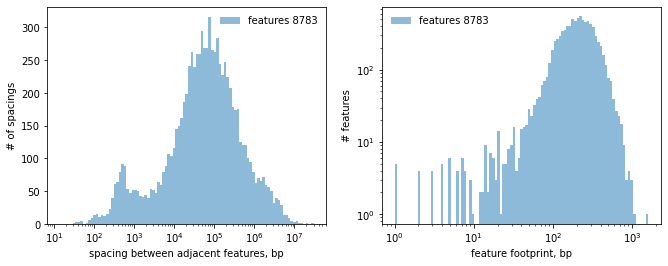

In [8]:
# calculate "spacing" between adjacent features,
# assuming coordinates are sorted !
plot_spacing_footprint_distros({k:df for k in ['features']})

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

number of candidate features before and after merging: 8783 -> 8633


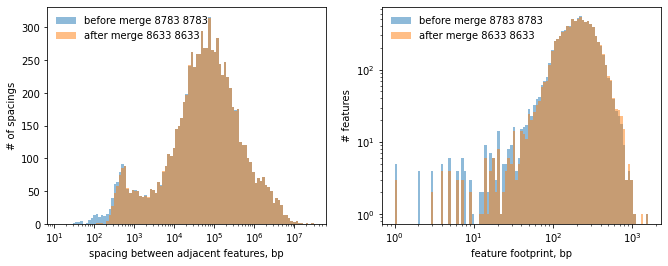

In [9]:
merge_radius = 100
df_merged = bf.merge(df, min_dist=merge_radius)

plot_spacing_footprint_distros({
    f"before merge {len(df)}":df,
    f"after merge {len(df_merged)}":df_merged,
})

print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [10]:
#let's describe our samples that we want to have in Figure 1 ...
# "ddx_CTCF","ddx_noCTCF"
# plot_samples = ['ddx_CTCF','ddx_noCTCF','taf5l_CTCF','taf5l_noCTCF','input_CTCF','input_noCTCF',"ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","polII","mrna_ctcf","mrna_noctcf"]
plot_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","h3k4_k562","polII","h3k4_r1","mrna_ctcf","mrna_noctcf"]
# CTCF/RAD21/ins/G4-seq/RNApolII/H3K4
# h3k4_k562

titles = plot_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in plot_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = None

### next is computation heavy step - stackups using bbi ...

In [11]:
# do all stackups with the parameters ...
stackups = {}
for s in bw_fnames:
    print(f"stacking up {s} ...")
    %time stackups[s] = rstacks( bw_fnames[s], df_merged, flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan  )

stacking up ctcf ...
CPU times: user 1.37 s, sys: 63.7 ms, total: 1.43 s
Wall time: 1.43 s
stacking up noctcf ...
CPU times: user 1.35 s, sys: 72 ms, total: 1.42 s
Wall time: 1.42 s
stacking up rad21_CTCF ...
CPU times: user 1.54 s, sys: 88.4 ms, total: 1.62 s
Wall time: 1.62 s
stacking up rad21_noCTCF ...
CPU times: user 1.25 s, sys: 46.5 ms, total: 1.3 s
Wall time: 1.3 s
stacking up ins_CTCF ...
CPU times: user 1.08 s, sys: 39.7 ms, total: 1.12 s
Wall time: 1.12 s
stacking up ins_noCTCF ...
CPU times: user 1.06 s, sys: 43.7 ms, total: 1.1 s
Wall time: 1.1 s
stacking up G4a_r2 ...
CPU times: user 1.83 s, sys: 71.9 ms, total: 1.9 s
Wall time: 1.89 s
stacking up h3k4_k562 ...
CPU times: user 3.16 s, sys: 99.3 ms, total: 3.26 s
Wall time: 3.25 s
stacking up polII ...
CPU times: user 1.12 s, sys: 31.8 ms, total: 1.16 s
Wall time: 1.16 s
stacking up h3k4_r1 ...
CPU times: user 1.77 s, sys: 83.4 ms, total: 1.86 s
Wall time: 1.85 s
stacking up mrna_ctcf ...
CPU times: user 1.08 s, sys: 76 ms

In [12]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
aaa = rstacks(
    "pcgene_plus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
bbb = rstacks(
    "pcgene_minus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
stackups[feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
plot_samples.append(feat_name)
titles = plot_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

In [13]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "ncgene"
aaa = rstacks(
    "ncgene_plus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
bbb = rstacks(
    "ncgene_minus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
stackups[feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
plot_samples.append(feat_name)
titles = plot_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

In [14]:
# turn G4-seq signal into stackup via bigBed:
annot_flank = 5_000
annot_binsize = 200
feat_name = "g4seq"
aaa = rstacks(
    "G4_polstall.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
stackups[feat_name] = aaa

    
#let's describe our samples that we want to have in Figure 1 ...
plot_samples.append(feat_name)
titles = plot_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (0,1)
cmps[s] = "Blues"
norms[s] = None

### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [15]:
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

# subtract = "mean_top"
# subtract_size = 7
normalize_insulation_stackups_INPLACE(
    stackups_set = stackups,
    ins_keys = insulation_keys
)

# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.452,-.153)
    cmps[s] = cmapYlGnBu_r

In [16]:
# turn RNA-seq into log-scale ... - probably should use "norm" instead !!!!
for s in ["mrna_ctcf", "mrna_noctcf"]:
    limss[s] = (0.,3)
for s in ["mrna_ctcf", "mrna_noctcf"]:
    stackups[s] = np.log(stackups[s])

### it's amazing how much you can do with a stack up !

we can flip certain rows !

_beware_ that we are reordering index this way, and we also might loos some rows from a stackup because of NaNs

In [17]:
length, width = stackups['G4a_r2'].shape
center_bin = int(width/2)

stackups['G4_mean'] = np.nanmean(stackups['G4a_r2'][:,center_bin-1:center_bin+1],axis=1)
stackups['K4_mean'] = np.nanmean(stackups['h3k4_r1'][:,center_bin-1:center_bin+1],axis=1)
stackups['gene_mean'] = np.nanmean(stackups['gene'][:,:],axis=1)
stackups['gene_mean'] = np.nanmean(stackups['ncgene'][:,:],axis=1)
# stackups['rna'] = np.nanmean(stackups['mrna_ctcf'][:,center_bin-4:center_bin+4],axis=1) - \
#                     np.nanmean(stackups['mrna_noctcf'][:,center_bin-4:center_bin+4],axis=1)
stackups['rna'] = np.abs(np.nanmean(stackups['mrna_ctcf'][:,:],axis=1))
stackups['mean_ctcf'] = np.nanmean(stackups['ctcf'][:,center_bin-2:center_bin+2],axis=1)


# # try to crudely sort by the G4-seq signal ...
# _df = df.copy()
# _df = bioframe.expand(_df,1000)
stackups['g4avg'] = np.nanmean(stackups['g4seq'][:,:],axis=1)


initial_index = np.arange( len(stackups['G4_mean']) )
ks = [('K4_mean', "sort", 1, False)]
_, jjj = recursive_data_ordering( ks, initial_index, stackups, verbose=True)


sorting 8633 elements of K4_mean into 1 groups ...


In [18]:
# #
# # skipping this for now ....
# #
CHUNK_SIZE = 100

# G4_polstall
index_chunks = chunked(df.loc[jjj].index, CHUNK_SIZE)
G4p_sorted = []
Number_of_chunks = 0
_df2 = G4_plus_polstall # works as is !!!
for ii in index_chunks:
    _df1 = df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
    G4p_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
    Number_of_chunks += 1

# G4_polstall
index_chunks = chunked(df.loc[jjj].index, CHUNK_SIZE)
G4m_sorted = []
Number_of_chunks = 0
_df2 = G4_minus_polstall # works as is !!!
for ii in index_chunks:
    _df1 = df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
    G4m_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
    Number_of_chunks += 1

In [28]:
for s in ["h3k4_k562",]:
    limss[s] = (1.,120)

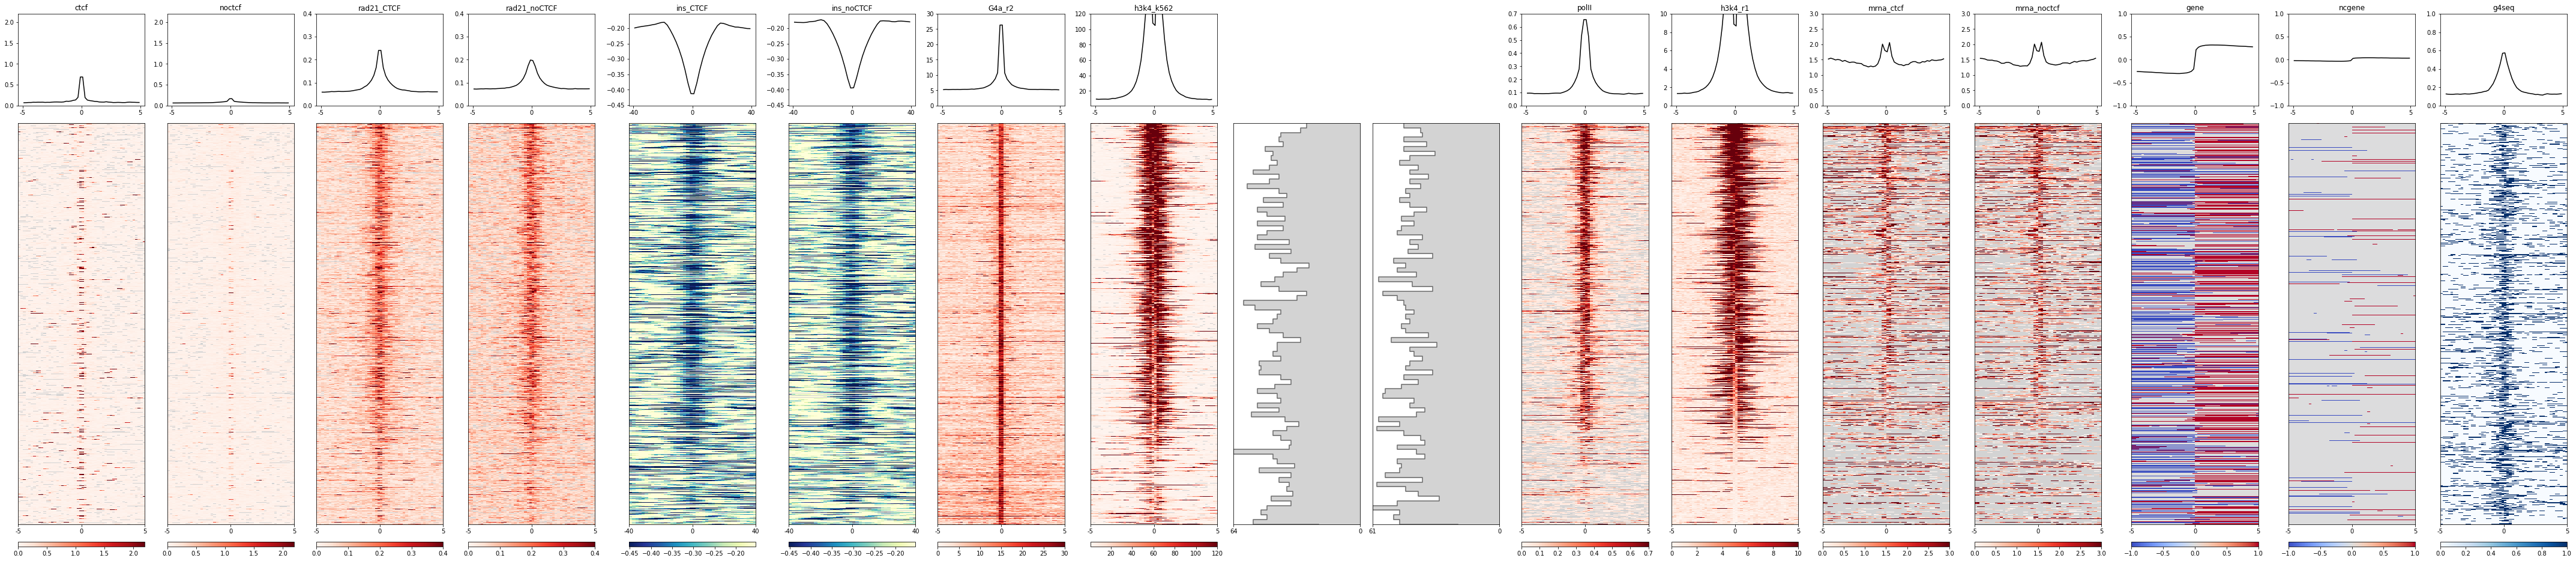

In [30]:
hmss = [ stackups[_k][jjj] for _k in plot_samples ]
_limss = [ limss[_k] for _k in plot_samples ]
_cmps = [ cmps[_k] for _k in plot_samples ]
_binsizes = [ binsizes[_k] for _k in plot_samples ]
_norms = [ norms[_k] for _k in plot_samples ]


# xtra_plots = [1,2]
extra_order = [8,9]
hmss_order = [0,1,2,3,4,5,6,7,10,11,12,13,14,15,16]
assert len(hmss_order) == len(plot_samples)
# xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# # xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group
xtra_axs = plot_stackups(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

# DEAL WITH XTRA PLOTS MANUALLY - AFTERWARDS ...

for col_index, y, width, color in [(extra_order[0], Number_of_chunks, G4p_sorted, "lightgrey"),
                                    (extra_order[1], Number_of_chunks, G4m_sorted, "lightgrey")]:
    common_width_max = max(width)
    _y = np.arange(y)
    _width = width
    _color = color
    xtra_axs[col_index].step(_width,_y,color="dimgray")
    xtra_axs[col_index].fill_betweenx(_y,0,_width,color=_color,step="post")
    xtra_axs[col_index].invert_yaxis()
    xtra_axs[col_index].invert_xaxis()
    xtra_axs[col_index].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
    xtra_axs[col_index].set_ylim(max(_y), 0)
    xtra_axs[col_index].set_xlim(common_width_max,0)
    xtra_axs[col_index].set_yticks([])
    xtra_axs[col_index].set_yticklabels([])   
    xtra_axs[col_index].set_xticks([])
    xtra_axs[col_index].set_xticklabels([])   
    xtra_axs[col_index].set_xticks([common_width_max,0])
    xtra_axs[col_index].set_xticklabels([common_width_max,0])

plt.savefig("G4Chippeaks-H3K4sorted.pdf")

In [31]:
!scp G4Chippeaks-H3K4sorted.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

G4Chippeaks-H3K4sorted.pdf                    100%  833KB 489.2KB/s   00:01    


In [ ]:
/nl/umw_job_dekker/users/sv49w/ALV2021/G4Chippeaks-H3K4sorted.pdf

In [20]:
# # let's take ~10'000 weakest CTCF harboring RAD21 peak
# iii = jjj[:10_000]

# _l, _w = stackups['ctcf'].shape
# _cent = int(_w/2)
# tmp_dict = {}
# tmp_dict['ctcf'] = np.nanmean(stackups['ctcf'][iii,_cent-3:_cent+3],axis=1)

# ks = [('ctcf', "sort", 1, False)]
# _, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)

# #######################################################################
# CHUNK_SIZE = 100

# # G4_polstall
# index_chunks = chunked(df.loc[iii[iii_reord]].index, CHUNK_SIZE)
# G4p_sorted = []
# Number_of_chunks = 0
# _df2 = G4_plus_polstall # works as is !!!
# for ii in index_chunks:
#     _df1 = df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
#     G4p_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
#     Number_of_chunks += 1

# # G4_polstall
# index_chunks = chunked(df.loc[iii[iii_reord]].index, CHUNK_SIZE)
# G4m_sorted = []
# Number_of_chunks = 0
# _df2 = G4_minus_polstall # works as is !!!
# for ii in index_chunks:
#     _df1 = df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
#     G4m_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
#     Number_of_chunks += 1
# #######################################################################

# hmss = [ stackups[_k][iii[iii_reord]] for _k in plot_samples ]
# _limss = [ limss[_k] for _k in plot_samples ]
# _cmps = [ cmps[_k] for _k in plot_samples ]
# _binsizes = [ binsizes[_k] for _k in plot_samples ]
# _norms = [ norms[_k] for _k in plot_samples ]

# # xtra_plots = [1,2]
# extra_order = [7,8]
# hmss_order = [0,  1,  2,  3,  4,  5,  6, 9, 10, 11, 12, 13,14,15]
# assert len(hmss_order) == len(plot_samples)

# # plot_stackups(None,hmss,titles,_limss,_cmps,_norms,_binsizes,fname="Fig1_masterlist_CTCFindep.pdf",fillmissing=False,interpolation="nearest")
# # # plot_stackups(None,hmss,titles,_limss,_cmps,_norms,_binsizes,fname="xxx.pdf",fillmissing=False,interpolation="nearest")
# # df_merged.loc[ iii[iii_reord] ][["chrom","start","end"]].to_csv("masterlist_CTCFindependent.bed",sep="\t",index=False,header=False)
# xtra_axs = plot_stackups(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

# # DEAL WITH XTRA PLOTS MANUALLY - AFTERWARDS ...

# for col_index, y, width, color in [(extra_order[0], Number_of_chunks, G4p_sorted, "lightgrey"),
#                                     (extra_order[1], Number_of_chunks, G4m_sorted, "lightgrey")]:
#     common_width_max = max(width)
#     _y = np.arange(y)
#     _width = width
#     _color = color
#     xtra_axs[col_index].step(_width,_y,color="dimgray")
#     xtra_axs[col_index].fill_betweenx(_y,0,_width,color=_color,step="post")
#     xtra_axs[col_index].invert_yaxis()
#     xtra_axs[col_index].invert_xaxis()
#     xtra_axs[col_index].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
#     xtra_axs[col_index].set_ylim(max(_y), 0)
#     xtra_axs[col_index].set_xlim(common_width_max,0)
#     xtra_axs[col_index].set_yticks([])
#     xtra_axs[col_index].set_yticklabels([])   
#     xtra_axs[col_index].set_xticks([])
#     xtra_axs[col_index].set_xticklabels([])   
#     xtra_axs[col_index].set_xticks([common_width_max,0])
#     xtra_axs[col_index].set_xticklabels([common_width_max,0])
